In [2]:
%tensorflow_version 2.x
import tensorflow as tf
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


# Adi and Lavanya code

Using Keras 1.2, And tensor Flow 1.x

In [3]:
from keras import models
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM, Input
from keras.layers import Dropout
from keras.layers import Conv1D, MaxPooling1D, Flatten, Conv2D, Reshape, ZeroPadding2D
from keras.models import Model
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import pickle
import keras
from keras.layers import Layer
from keras.layers import Activation, Dense



In [4]:
print(tf.__version__)

2.4.1


In [5]:
#Mounting Google Drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [6]:
#De-Pickling Data with encoding latin1
with open("/content/drive/MyDrive/Colab Notebooks/UGP_data/RML2016.10a_dict.pickle", 'rb') as f:
    Xd = pickle.load(f, encoding='latin1')

In [7]:
classes = ['32PSK', '16APSK', '32QAM', 'FM', 'GMSK', '32APSK', 'OQPSK', #1
 '8ASK', 'BPSK','8PSK', 'AM-SSB-SC', '4ASK', '16PSK', '64APSK', '128QAM', '128APSK','AM-DSB-SC', #2 
'AM-SSB-WC', '64QAM', 'QPSK', '256QAM','AM-DSB-WC','OOK','16QAM']


In [8]:
snrs,mods = map(lambda j: sorted(list(set(map(lambda x: x[j], Xd.keys())))), [1,0])
X = []
lbl = []
for mod in mods:
    for snr in snrs:
        X.append(Xd[(mod,snr)])
        for i in range(Xd[(mod,snr)].shape[0]):  lbl.append((mod,snr))
X = np.vstack(X)

In [9]:
np.random.seed(2016)  # 对预处理好的数据进行打包，制作成投入网络训练的格式，并进行one-hot编码
n_examples = X.shape[0]
n_train = n_examples * 0.5  # 对半
train_idx = np.random.choice(range(0, n_examples), size=int(n_train), replace=False)
test_idx = list(set(range(0, n_examples)) - set(train_idx))  # label
X_train = X[train_idx]
X_test = X[test_idx]

In [10]:
def to_onehot(yy):
    yy1 = np.zeros([len(yy), max(yy) + 1])
    yy1[np.arange(len(yy)), yy] = 1
    return yy1


In [11]:
trainy = list(map(lambda x: mods.index(lbl[x][0]), train_idx))
Y_train = to_onehot(trainy)
Y_test = to_onehot(list(map(lambda x: mods.index(lbl[x][0]), test_idx)))

In [12]:
in_shp = list(X_train.shape[1:])
print (X_train.shape, in_shp)
classes = mods
# %%
dr = 0.5  # dropout rate (%) 卷积层部分  https://keras-cn.readthedocs.io/en/latest/layers/convolutional_layer/#conv2d
#model = models.Sequential()  # 这里使用keras的序贯模型  https://keras-cn.readthedocs.io/en/latest/models/sequential/
# Reshape [N,2,128] to [N,2,128,1] on input

(110000, 2, 128) [2, 128]


In [13]:
maxlen = 128 # change subnyq sampling rate HERE.

def gendata(fp, nsamples):
    global snrs, mods, train_idx, test_idx, lbl
    with open(fp, 'rb') as f:
      Xd = pickle.load(f, encoding='latin1')
    
    snrs,mods = map(lambda j: sorted(list(set(map(lambda x: x[j], Xd.keys())))), [1,0])
    X = []  
    lbl = []
    for mod in mods:
      for snr in snrs:
        X.append(Xd[(mod, snr)])
        for i in range(Xd[(mod, snr)].shape[0]):
          lbl.append((mod, snr))
    X = np.vstack(X)
    
    print('Length of lbl', len(lbl))
    print('shape of X', X.shape)

    np.random.seed(2016)
    n_example = X.shape[0]
    n_train = n_example * 0.5
    train_idx = np.random.choice(range(0,n_example), size=int(n_train), replace=False)
    test_idx = list(set(range(0, n_example)) - set(train_idx))
    X_train = X[train_idx]
    X_test =  X[test_idx]
    
    def to_onehot(vec):
      vec_hot = np.zeros([len(vec), max(vec) + 1])
      vec_hot[np.arange(len(vec)), vec] = 1
      return vec_hot
    
    Y_train = to_onehot(list(map(lambda x: mods.index(lbl[x][0]), train_idx)))
    Y_test = to_onehot(list(map(lambda x: mods.index(lbl[x][0]), test_idx)))

    return (X_train,X_test,Y_train,Y_test)

def norm_pad_zeros(X_train,nsamples):
    print ("Pad:", X_train.shape)
    for i in range(X_train.shape[0]):
        X_train[i,:,0] = X_train[i,:,0]/la.norm(X_train[i,:,0],2)
    return X_train


def to_amp_phase(X_train,X_test,nsamples):
    X_train_cmplx = X_train[:,0,:] + 1j* X_train[:,1,:]
    X_test_cmplx = X_test[:,0,:] + 1j* X_test[:,1,:]
    
    X_train_amp = np.abs(X_train_cmplx)
    X_train_ang = np.arctan2(X_train[:,1,:],X_train[:,0,:])/np.pi
  

    X_train_amp = np.reshape(X_train_amp,(-1,1,nsamples))
    X_train_ang = np.reshape(X_train_ang,(-1,1,nsamples))
   
    X_train = np.concatenate((X_train_amp,X_train_ang), axis=1) 
    X_train = np.transpose(np.array(X_train),(0,2,1))
    
    X_test_amp = np.abs(X_test_cmplx)
    X_test_ang = np.arctan2(X_test[:,1,:],X_test[:,0,:])/np.pi
    
    
    X_test_amp = np.reshape(X_test_amp,(-1,1,nsamples))
    X_test_ang = np.reshape(X_test_ang,(-1,1,nsamples))
    
    X_test = np.concatenate((X_test_amp,X_test_ang), axis=1) 
    X_test = np.transpose(np.array(X_test),(0,2,1))

    X_train = np.transpose(X_train,axes=(0,2,1))
    X_test = np.transpose(X_test,axes=(0,2,1))
    return (X_train, X_test)

In [14]:
xtrain1,xtest1,ytrain1,ytest1= gendata("/content/drive/MyDrive/Colab Notebooks/UGP_data/RML2016.10a_dict.pickle",maxlen)
print(xtrain1.shape)
print(ytrain1.shape)

Length of lbl 220000
shape of X (220000, 2, 128)
(110000, 2, 128)
(110000, 11)


In [15]:
print('length of X before to_amp_phase:', xtrain1.shape)
X_train_ap,X_test_ap = to_amp_phase(xtrain1,xtest1,maxlen)
print('length of X after to_amp_phase:', xtrain1.shape)
X_train_iq, Y_train_iq = xtrain1, ytrain1
X_test_iq, Y_test_iq = xtest1, ytest1
Y_train_ap, Y_test_ap = ytrain1, ytest1

length of X before to_amp_phase: (110000, 2, 128)
length of X after to_amp_phase: (110000, 2, 128)


In [16]:
print("--"*50)
print("Training data for 1st Stream: ",X_train_ap.shape)
print("Training labels for 1st Stream: ",Y_train_ap.shape)
print("Testing data for 1st Stream: ",X_test_ap.shape)
print("Testing labels for 1st Stream: ",Y_test_ap.shape)
print("--"*50)
print("Training data for 2nd Stream: ",X_train_iq.shape)
print("Training labels for 2nd Stream :",Y_train_iq.shape)
print("Testing data for 2nd Stream :  ",X_test_iq.shape)
print("Testing labels for 2nd Stream : ",Y_test_iq.shape)
print("--"*50)

----------------------------------------------------------------------------------------------------
Training data for 1st Stream:  (110000, 2, 128)
Training labels for 1st Stream:  (110000, 11)
Testing data for 1st Stream:  (110000, 2, 128)
Testing labels for 1st Stream:  (110000, 11)
----------------------------------------------------------------------------------------------------
Training data for 2nd Stream:  (110000, 2, 128)
Training labels for 2nd Stream : (110000, 11)
Testing data for 2nd Stream :   (110000, 2, 128)
Testing labels for 2nd Stream :  (110000, 11)
----------------------------------------------------------------------------------------------------


In [17]:
X_train_ap=np.reshape(X_train_ap,(-1,2,128,1))
X_test_ap=np.reshape(X_test_ap,(-1,2,128,1))
X_train_iq=np.reshape(X_train_iq,(-1,2,128,1))
X_test_iq=np.reshape(X_test_iq,(-1,2,128,1))

In [18]:
X_test=np.reshape(X_test,(-1,2,128,1))

In [19]:
import keras.backend as K

In [21]:
from keras.layers import Conv1D, MaxPooling1D, Flatten, Conv2D, Reshape, ZeroPadding2D
from keras.layers import *
from keras.models import Model
from tensorflow.keras import layers
from tensorflow.keras import regularizers

In [22]:
input_x = Input(shape=(2, 128,1))

input_x_padding = ZeroPadding2D((0, 2))(input_x)

layer1 = Conv2D(256, (1, 3), padding='valid', activation="relu", name="conv1")(input_x_padding)
layer1 = Dropout(dr)(layer1)
layer1_padding = ZeroPadding2D((0, 2), data_format="channels_first")(layer1)
print(layer1_padding.shape)
layer2 = Conv2D(256, (2, 3), padding="valid", activation="relu", name="conv2", kernel_initializer='glorot_uniform')(layer1_padding)
layer2 = Dropout(dr)(layer2)
layer2_padding = ZeroPadding2D((0, 2), data_format="channels_first")(layer2)

layer3 = Conv2D(80, (1, 3), padding='valid', activation="relu", name="conv3", kernel_initializer='glorot_uniform',kernel_regularizer=regularizers.l1_l2(l1=1e-5, l2=1e-4))(layer2)
layer3 = Dropout(dr)(layer3)


model1 = Model(inputs=input_x, outputs=layer3)

model1.compile()

model1.summary()

(None, 2, 130, 260)
Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 2, 128, 1)]       0         
_________________________________________________________________
zero_padding2d_3 (ZeroPaddin (None, 2, 132, 1)         0         
_________________________________________________________________
conv1 (Conv2D)               (None, 2, 130, 256)       1024      
_________________________________________________________________
dropout_2 (Dropout)          (None, 2, 130, 256)       0         
_________________________________________________________________
zero_padding2d_4 (ZeroPaddin (None, 2, 130, 260)       0         
_________________________________________________________________
conv2 (Conv2D)               (None, 1, 128, 256)       399616    
_________________________________________________________________
dropout_3 (Dropout)          (None, 1, 12

In [23]:
input_x = Input(shape=(2, 128,1))

input_x_padding = ZeroPadding2D((0, 2))(input_x)

layer1 = Conv2D(256, (1, 3), padding='valid', activation="relu", name="conv11")(input_x_padding)
layer1 = Dropout(dr)(layer1)
layer1_padding = ZeroPadding2D((0, 2), data_format="channels_first")(layer1)
print(layer1_padding.shape)
layer2 = Conv2D(256, (2, 3), padding="valid", activation="relu", name="conv22", kernel_initializer='glorot_uniform')(layer1_padding)
layer2 = Dropout(dr)(layer2)
layer2_padding = ZeroPadding2D((0, 2), data_format="channels_first")(layer2)

layer3 = Conv2D(80, (1, 3), padding='valid', activation="relu", name="conv33", kernel_initializer='glorot_uniform',kernel_regularizer=regularizers.l1_l2(l1=1e-5, l2=1e-4))(layer2)
layer3 = Dropout(dr)(layer3)


model2 = Model(inputs=input_x, outputs=layer3)

model2.compile()

model2.summary()

(None, 2, 130, 260)
Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 2, 128, 1)]       0         
_________________________________________________________________
zero_padding2d_6 (ZeroPaddin (None, 2, 132, 1)         0         
_________________________________________________________________
conv11 (Conv2D)              (None, 2, 130, 256)       1024      
_________________________________________________________________
dropout_5 (Dropout)          (None, 2, 130, 256)       0         
_________________________________________________________________
zero_padding2d_7 (ZeroPaddin (None, 2, 130, 260)       0         
_________________________________________________________________
conv22 (Conv2D)              (None, 1, 128, 256)       399616    
_________________________________________________________________
dropout_6 (Dropout)          (None, 1, 

In [24]:
mergedOut = Concatenate()([model1.output,model2.output]) 
# output layer
mergedOut = Flatten()(mergedOut)
mergedOut = Dense(256, kernel_regularizer=regularizers.l1_l2(l1=1e-5, l2=1e-4))(mergedOut)
mergedOut = Dropout(dr)(mergedOut)
mergedOut = Dense(11, activation='softmax')(mergedOut)
newModel = Model([model1.input,model2.input], mergedOut)
newModel.compile(loss=keras.losses.categorical_crossentropy,optimizer=keras.optimizers.Adam(lr=0.00018),metrics=['accuracy'])
newModel.summary()

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 2, 128, 1)]  0                                            
__________________________________________________________________________________________________
input_3 (InputLayer)            [(None, 2, 128, 1)]  0                                            
__________________________________________________________________________________________________
zero_padding2d_3 (ZeroPadding2D (None, 2, 132, 1)    0           input_2[0][0]                    
__________________________________________________________________________________________________
zero_padding2d_6 (ZeroPadding2D (None, 2, 132, 1)    0           input_3[0][0]                    
____________________________________________________________________________________________

In [25]:
batch_size=1024
epochs=100
filepath = 'weight_4layers.wts.h5'
history = newModel.fit([X_train_ap,X_train_iq],
                    Y_train,
                    batch_size=1024,
                    epochs=100,
                    verbose=1, use_multiprocessing = True,
                    validation_data=([X_test_ap,X_test_iq],Y_test)
                    ,callbacks = [keras.callbacks.ModelCheckpoint(filepath, monitor='val_loss', verbose=0, save_best_only=True, mode='auto'),
                 keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, verbose=0, mode='auto')
    ])



Epoch 1/100
108/108 [==============================] - 86s 480ms/step - loss: 2.7495 - accuracy: 0.1681 - val_loss: 2.4454 - val_accuracy: 0.2233
Epoch 2/100
108/108 [==============================] - 51s 472ms/step - loss: 2.4294 - accuracy: 0.2224 - val_loss: 2.3373 - val_accuracy: 0.2488
Epoch 3/100
108/108 [==============================] - 50s 468ms/step - loss: 2.3050 - accuracy: 0.2598 - val_loss: 2.1600 - val_accuracy: 0.2938
Epoch 4/100
108/108 [==============================] - 50s 467ms/step - loss: 2.1533 - accuracy: 0.2945 - val_loss: 2.0416 - val_accuracy: 0.3309
Epoch 5/100
108/108 [==============================] - 50s 468ms/step - loss: 2.0479 - accuracy: 0.3236 - val_loss: 1.8949 - val_accuracy: 0.3685
Epoch 6/100
108/108 [==============================] - 50s 467ms/step - loss: 1.9217 - accuracy: 0.3575 - val_loss: 1.8163 - val_accuracy: 0.3874
Epoch 7/100
108/108 [==============================] - 50s 467ms/step - loss: 1.8442 - accuracy: 0.3801 - val_loss: 1.7752 -

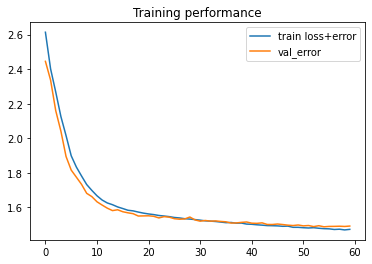

In [26]:
# Show loss curves
plt.figure()
plt.title('Training performance')
plt.plot(history.epoch, history.history['loss'], label='train loss+error')
plt.plot(history.epoch, history.history['val_loss'], label='val_error')
plt.legend()











In [27]:
acc = {}
for snr in snrs:
  # extract classes @ SNR
  test_SNRs = list(map(lambda x: lbl[x][1], test_idx))
  test_X_i_ap = X_test_ap[np.where(np.array(test_SNRs)==snr)]
  test_X_i_iq = X_test_iq[np.where(np.array(test_SNRs)==snr)]
  test_Y_i = Y_test[np.where(np.array(test_SNRs)==snr)]
  # estimate classes
  test_Y_i_hat = newModel.predict([test_X_i_ap,test_X_i_iq])
  conf = np.zeros([len(classes),len(classes)])
  confnorm = np.zeros([len(classes),len(classes)])
  for i in range(0,test_X_i_ap.shape[0]):
    j = list(test_Y_i[i,:]).index(1)
    k = int(np.argmax(test_Y_i_hat[i,:]))
    conf[j,k] = conf[j,k] + 1

  for i in range(0,len(classes)):
    confnorm[i,:] = conf[i,:] / np.sum(conf[i,:])

  #plt.figure()
  #plot_confusion_matrix(confnorm, labels=classes, title="ConvNet Confusion Matrix (SNR=%d)"%(snr))
  cor = np.sum(np.diag(conf))
  ncor = np.sum(conf) - cor
  print("SNR: ",snr, " Overall Accuracy: ", cor / (cor + ncor))
  acc[snr] = 1.0 * cor / (cor + ncor)

SNR:  -20  Overall Accuracy:  0.0969807868252516
SNR:  -18  Overall Accuracy:  0.09100817438692098
SNR:  -16  Overall Accuracy:  0.09352387843704775
SNR:  -14  Overall Accuracy:  0.09599422591122339
SNR:  -12  Overall Accuracy:  0.12014585232452142
SNR:  -10  Overall Accuracy:  0.16865114625910788
SNR:  -8  Overall Accuracy:  0.2630902076060996
SNR:  -6  Overall Accuracy:  0.36693548387096775
SNR:  -4  Overall Accuracy:  0.4502772643253235
SNR:  -2  Overall Accuracy:  0.5428156748911466
SNR:  0  Overall Accuracy:  0.6572992700729927
SNR:  2  Overall Accuracy:  0.7302798982188295
SNR:  4  Overall Accuracy:  0.7718428781204112
SNR:  6  Overall Accuracy:  0.7953068592057762
SNR:  8  Overall Accuracy:  0.8032461677186654
SNR:  10  Overall Accuracy:  0.7983606557377049
SNR:  12  Overall Accuracy:  0.7848995111352526
SNR:  14  Overall Accuracy:  0.8045764901273298
SNR:  16  Overall Accuracy:  0.7938461538461539
SNR:  18  Overall Accuracy:  0.7945994599459946


{-20: 0.0969807868252516, -18: 0.09100817438692098, -16: 0.09352387843704775, -14: 0.09599422591122339, -12: 0.12014585232452142, -10: 0.16865114625910788, -8: 0.2630902076060996, -6: 0.36693548387096775, -4: 0.4502772643253235, -2: 0.5428156748911466, 0: 0.6572992700729927, 2: 0.7302798982188295, 4: 0.7718428781204112, 6: 0.7953068592057762, 8: 0.8032461677186654, 10: 0.7983606557377049, 12: 0.7848995111352526, 14: 0.8045764901273298, 16: 0.7938461538461539, 18: 0.7945994599459946}


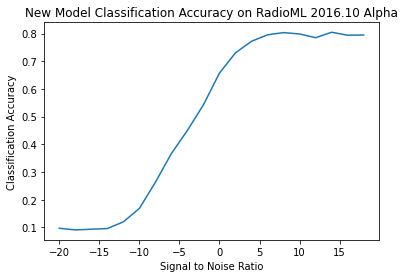

In [28]:
print(acc)
fd = open('results_cnn_d0.5.dat','wb')
pickle.dump( ("CNN", 0.5, acc) , fd )

# Plot accuracy curve
plt.plot(snrs, list(map(lambda x: acc[x], snrs)))
plt.xlabel("Signal to Noise Ratio")
plt.ylabel("Classification Accuracy")
plt.title("New Model Classification Accuracy on RadioML 2016.10 Alpha")
plt.show()

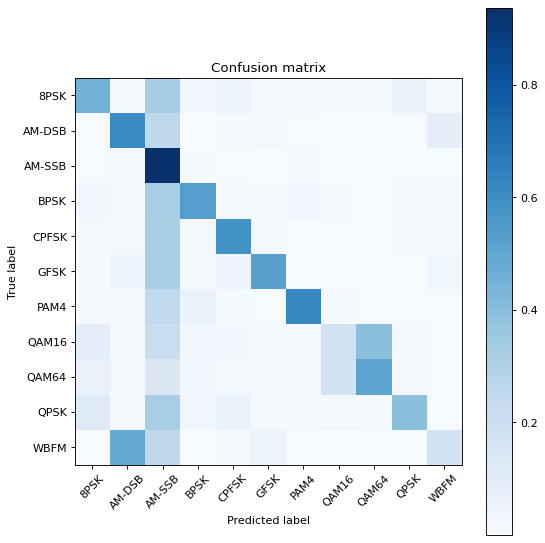

In [29]:
def plot_confusion_matrix(cm, title='Confusion matrix', cmap=plt.cm.Blues, labels=[]):
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(labels))
    plt.xticks(tick_marks, labels, rotation=45)
    plt.yticks(tick_marks, labels)
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()


test_Y_hat = newModel.predict([X_test_ap,X_test_iq], batch_size=1024)
conf = np.zeros([len(classes),len(classes)])
confnorm = np.zeros([len(classes),len(classes)])
for i in range(0,X_test.shape[0]):
    j = list(Y_test[i,:]).index(1)
    k = int(np.argmax(test_Y_hat[i,:]))
    conf[j,k] = conf[j,k] + 1
for i in range(0,len(classes)):
    confnorm[i,:] = conf[i,:] / np.sum(conf[i,:])

plt.figure(num=None, figsize=(7, 7), dpi=80, facecolor='w', edgecolor='black')
plot_confusion_matrix(confnorm, labels=classes)

# Updated(DeviJi)

In [ ]:
import numpy as np
import os
os.environ["KERAS_BACKEND"] = "tensorflow"
import keras
from keras.utils import np_utils
import keras.models as models
from keras.layers.core import Reshape,Dense,Dropout,Activation,Flatten
from keras.layers.convolutional import Conv2D, MaxPooling2D, ZeroPadding2D
from keras.regularizers import *
from keras.optimizers import Adam
import tensorflow as tf
from sklearn.metrics import confusion_matrix
import matplotlib
matplotlib.use('Agg')
import pickle
import matplotlib.pyplot as plt
import sys
import operator
from numpy import linalg as la 
from math import ceil
##from keras.utils import multi_gpu_model
from keras import backend as K

In [ ]:
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
import seaborn as sns


In [ ]:
#Mounting Google Drive
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
# import modules
from IPython.display import display, clear_output
import numpy as np
import os
# import deep learning libraries
import os
import keras
import pickle
from keras import layers
from keras.utils import to_categorical
from keras.models import Model, load_model
from keras.initializers import glorot_uniform
from keras.layers import Input, Dropout, Add, Dense, Reshape, Activation
from keras.layers import BatchNormalization, Flatten, Conv1D, MaxPooling1D

In [ ]:
import os,random
os.environ["KERAS_BACKEND"] = "tensorflow"
from tensorflow.keras import layers
import numpy as np
from keras.utils import np_utils
import keras.models as models
from keras.layers.core import Reshape,Dense,Dropout,Activation,Flatten
from keras.layers.noise import GaussianNoise
from keras.layers.convolutional import Conv2D, MaxPooling2D, ZeroPadding2D
from keras.regularizers import *
from tensorflow.python.keras.optimizer_v2.adam import Adam
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
import seaborn as sns
import pickle, random, sys, keras
import h5py

In [ ]:
maxlen = 128 # change subnyq sampling rate HERE.

def gendata(fp, nsamples):
    global snrs, mods, train_idx, test_idx, lbl
    with open(fp, 'rb') as f:
      Xd = pickle.load(f, encoding='latin1')
    
    snrs,mods = map(lambda j: sorted(list(set(map(lambda x: x[j], Xd.keys())))), [1,0])
    X = []  
    lbl = []
    for mod in mods:
      for snr in snrs:
        X.append(Xd[(mod, snr)])
        for i in range(Xd[(mod, snr)].shape[0]):
          lbl.append((mod, snr))
    X = np.vstack(X)
    
    print('Length of lbl', len(lbl))
    print('shape of X', X.shape)

    np.random.seed(2016)
    n_example = X.shape[0]
    n_train = n_example * 0.5
    train_idx = np.random.choice(range(0,n_example), size=int(n_train), replace=False)
    test_idx = list(set(range(0, n_example)) - set(train_idx))
    X_train = X[train_idx]
    X_test =  X[test_idx]
    
    def to_onehot(vec):
      vec_hot = np.zeros([len(vec), max(vec) + 1])
      vec_hot[np.arange(len(vec)), vec] = 1
      return vec_hot
    
    Y_train = to_onehot(list(map(lambda x: mods.index(lbl[x][0]), train_idx)))
    Y_test = to_onehot(list(map(lambda x: mods.index(lbl[x][0]), test_idx)))

    return (X_train,X_test,Y_train,Y_test)

def norm_pad_zeros(X_train,nsamples):
    print ("Pad:", X_train.shape)
    for i in range(X_train.shape[0]):
        X_train[i,:,0] = X_train[i,:,0]/la.norm(X_train[i,:,0],2)
    return X_train


def to_amp_phase(X_train,X_test,nsamples):
    X_train_cmplx = X_train[:,0,:] + 1j* X_train[:,1,:]
    X_test_cmplx = X_test[:,0,:] + 1j* X_test[:,1,:]
    
    X_train_amp = np.abs(X_train_cmplx)
    X_train_ang = np.arctan2(X_train[:,1,:],X_train[:,0,:])/np.pi
  

    X_train_amp = np.reshape(X_train_amp,(-1,1,nsamples))
    X_train_ang = np.reshape(X_train_ang,(-1,1,nsamples))
   
    X_train = np.concatenate((X_train_amp,X_train_ang), axis=1) 
    X_train = np.transpose(np.array(X_train),(0,2,1))
    
    X_test_amp = np.abs(X_test_cmplx)
    X_test_ang = np.arctan2(X_test[:,1,:],X_test[:,0,:])/np.pi
    
    
    X_test_amp = np.reshape(X_test_amp,(-1,1,nsamples))
    X_test_ang = np.reshape(X_test_ang,(-1,1,nsamples))
    
    X_test = np.concatenate((X_test_amp,X_test_ang), axis=1) 
    X_test = np.transpose(np.array(X_test),(0,2,1))

    X_train = np.transpose(X_train,axes=(0,2,1))
    X_test = np.transpose(X_test,axes=(0,2,1))
    return (X_train, X_test)


In [ ]:
xtrain1,xtest1,ytrain1,ytest1= gendata("/content/drive/My Drive/Colab Notebooks/DATA/Lavanya/RML2016.10a_dict.pickle.pkl",maxlen)
print(xtrain1.shape)
print(ytrain1.shape)                
#print('using version 10a dataset')
#test_SNRs = map(lambda x: lbl[x][1], test_idx)
#train_SNRs = map(lambda x: lbl[x][1], train_idx)
#train_snr = lambda snr: xtrain1[np.where(np.array(train_SNRs)==snr)]
#test_snr = lambda snr: ytrain1[np.where(np.array(train_SNRs)==snr)]


In [ ]:
print('length of X before to_amp_phase:', xtrain1.shape)
X_train_ap,X_test_ap = to_amp_phase(xtrain1,xtest1,maxlen)
print('length of X after to_amp_phase:', xtrain1.shape)
X_train_iq, Y_train_iq = xtrain1, ytrain1
X_test_iq, Y_test_iq = xtest1, ytest1
Y_train_ap, Y_test_ap = ytrain1, ytest1

In [ ]:
print("--"*50)
print("Training data for 1st Stream: ",X_train_ap.shape)
print("Training labels for 1st Stream: ",Y_train_ap.shape)
print("Testing data for 1st Stream: ",X_test_ap.shape)
print("Testing labels for 1st Stream: ",Y_test_ap.shape)
print("--"*50)
print("Training data for 2nd Stream: ",X_train_iq.shape)
print("Training labels for 2nd Stream :",Y_train_iq.shape)
print("Testing data for 2nd Stream :  ",X_test_iq.shape)
print("Testing labels for 2nd Stream : ",Y_test_iq.shape)
print("--"*50)

In [ ]:
X_train_ap=np.reshape(X_train_ap,(-1,2,128,1))
X_test_ap=np.reshape(X_test_ap,(-1,2,128,1))
X_train_iq=np.reshape(X_train_iq,(-1,2,128,1))
X_test_iq=np.reshape(X_test_iq,(-1,2,128,1))

In [ ]:
dr=0.1

In [ ]:
model1 = Sequential()
model1.add(ZeroPadding2D((0,2),input_shape=(X_train_ap.shape[1],X_train_ap.shape[2],X_train_ap.shape[3])))
model1.add(Conv2D(50, (1, 8), padding='valid', activation="relu", name="conv11", kernel_initializer='glorot_uniform'))
model1.add(Dropout(dr))
model1.add(ZeroPadding2D((0, 2)))
model1.add(Conv2D(50, (1, 8), padding='valid', activation="relu", name="conv12", kernel_initializer='glorot_uniform'))
model1.add(Dropout(dr))
model1.add(ZeroPadding2D((0, 2)))
model1.add(Conv2D(50, (1, 8), padding='valid', activation="relu", name="conv13", kernel_initializer='glorot_uniform'))
model1.add(Dropout(dr))
model1.add(ZeroPadding2D((0, 2)))

In [ ]:
layer11 = Conv2D(50, (1, 8), padding='valid', activation="relu", name="conv11", kernel_initializer='glorot_uniform'
                 )(input_x_padding)
layer11 = Dropout(dr)(layer11)

layer11_padding = ZeroPadding2D((0, 2))(layer11)
layer12 = Conv2D(50, (1, 8), padding="valid", activation="relu", name="conv12", kernel_initializer='glorot_uniform'
                )(layer11_padding)
layer12 = Dropout(dr)(layer12)

layer12 = ZeroPadding2D((0, 2))(layer12)
layer13 = Conv2D(50, (1, 8), padding='valid', activation="relu", name="conv13", kernel_initializer='glorot_uniform'
                 )(layer12)
layer13 = Dropout(dr)(layer13)

In [ ]:
#LSTM
concat = keras.layers.concatenate([layer11, layer13],axis=2)
concat_size = list(np.shape(concat))
input_dim = int(concat_size[-1] * concat_size[-2])
timesteps = int(concat_size[-3])
# concat = np.reshape(concat, (-1,timesteps,input_dim))
concat = Reshape((timesteps, input_dim))(concat)
# 形如（samples，timesteps，input_dim）的3D张量
lstm_out = LSTM(50, input_dim=input_dim, input_length=timesteps)(concat)

In [ ]:
print(input_dim,timesteps)

In [ ]:
model1.add(Reshape((timesteps, 6150)))
model1.add(LSTM(50, input_dim=input_dim, name="lstm1",input_length=timesteps))
model1.add(Dense(256, activation='relu', kernel_initializer='he_normal', name="dense1"))
model1.add(Dropout(dr))
model1.add(Dense(11, activation='relu', kernel_initializer='he_normal', name="dense2"))
model1.add(Dense(11,activation='softmax'))
model1.compile(optimizer = 'adam', loss = 'categorical_crossentropy',metrics=['accuracy'])
model1.summary()

In [ ]:
filepath = "dual_cnn_lstm_adi_%s_0.5.wts.h5" 

In [ ]:
history = model1.fit(X_train_ap,
                    Y_train_ap,
                    batch_size=64,
                    epochs=100,
                    verbose=2,
                    validation_data=(X_test_ap, Y_test_ap),
                    callbacks=[  # 回调函数，https://keras-cn.readthedocs.io/en/latest/other/callbacks/
                        keras.callbacks.ModelCheckpoint(filepath, monitor='val_loss', verbose=0, save_best_only=True,
                                                        mode='auto'),
                        keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, verbose=0, mode='auto')
                    ])  # EarlyStopping 当监测值不再改善时，该回调函数将中止训练，如去除本行将执行所有epoch


In [ ]:
# Second Stream
model2 = Sequential()
model2.add(ZeroPadding2D((0,2),input_shape=(X_train_iq.shape[1],X_train_iq.shape[2],X_train_iq.shape[3])))
model2.add(Conv2D(50, (1, 8), padding='valid', activation="relu", name="conv11", kernel_initializer='glorot_uniform'))
model2.add(Dropout(dr))
model2.add(ZeroPadding2D((0, 2)))
model2.add(Conv2D(50, (1, 8), padding='valid', activation="relu", name="conv12", kernel_initializer='glorot_uniform'))
model2.add(Dropout(dr))
model2.add(ZeroPadding2D((0, 2)))
model2.add(Conv2D(50, (1, 8), padding='valid', activation="relu", name="conv13", kernel_initializer='glorot_uniform'))
model2.add(Dropout(dr))
model2.add(ZeroPadding2D((0, 2)))

layer11_iq = Conv2D(50, (1, 8), padding='valid', activation="relu", name="conv11", kernel_initializer='glorot_uniform'
                 )(input_x_padding)
layer11_iq = Dropout(dr)(layer11)

layer11_padding_iq = ZeroPadding2D((0, 2))(layer11)
layer12_iq = Conv2D(50, (1, 8), padding="valid", activation="relu", name="conv12", kernel_initializer='glorot_uniform'
                )(layer11_padding)
layer12_iq = Dropout(dr)(layer12)

layer12_iq = ZeroPadding2D((0, 2))(layer12)
layer13_iq = Conv2D(50, (1, 8), padding='valid', activation="relu", name="conv13", kernel_initializer='glorot_uniform'
                 )(layer12)
layer13_iq = Dropout(dr)(layer13)

#LSTM
concat = keras.layers.concatenate([layer11_iq, layer13_iq],axis=2)
concat_size = list(np.shape(concat))
input_dim = int(concat_size[-1] * concat_size[-2])
timesteps = int(concat_size[-3])
# concat = np.reshape(concat, (-1,timesteps,input_dim))
concat = Reshape((timesteps, input_dim))(concat)
# 形如（samples，timesteps，input_dim）的3D张量
lstm_out = LSTM(50, input_dim=input_dim, input_length=timesteps)(concat)

model2.add(Reshape((timesteps, 6150)))
model2.add(LSTM(50, input_dim=input_dim, name="lstm1",input_length=timesteps))
model2.add(Dense(256, activation='relu', kernel_initializer='he_normal', name="dense1"))
model2.add(Dropout(dr))
model2.add(Dense(11, activation='relu', kernel_initializer='he_normal', name="dense2"))
model2.add(Dense(11,activation='softmax'))
model2.compile(optimizer = 'adam', loss = 'categorical_crossentropy',metrics=['accuracy'])
model2.summary()

In [ ]:
filepath = "dual_iq__cnn_lstm_adi_%s_0.5.wts.h5" 
history = model1.fit(X_train_iq,
                    Y_train_iq,
                    batch_size=64,
                    epochs=100,
                    verbose=2,
                    validation_data=(X_test_iq, Y_test_iq),
                    callbacks=[  # 回调函数，https://keras-cn.readthedocs.io/en/latest/other/callbacks/
                        keras.callbacks.ModelCheckpoint(filepath, monitor='val_loss', verbose=0, save_best_only=True,
                                                        mode='auto'),
                        keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, verbose=0, mode='auto')
                    ])  # EarlyStopping 当监测值不再改善时，该回调函数将中止训练，如去除本行将执行所有epoch
